In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from scripts.load_data import load_data_from_postgres, load_data_using_sqlalchemy

%matplotlib inline

In [170]:
query = 'SELECT * FROM xdr_data'
df = load_data_using_sqlalchemy(query)

df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,7.349883e+18,4/23/2019 13:56,642.0,4/25/2019 2:06,53.0,130220.0,2.082003e+14,3.368112e+10,3.572961e+13,T10006B,...,21500768.0,12101768.0,12226975.0,16511157.0,340225685.0,6951608.0,483022848.0,13524725.0,50864502.0,388912579.0
1,1.311448e+19,4/23/2019 14:00,501.0,4/24/2019 23:17,453.0,119804.0,2.082014e+14,3.369966e+10,3.561431e+13,T92938B,...,7277265.0,14808877.0,5404356.0,17848389.0,281827903.0,3255023.0,746150700.0,1475289.0,38549811.0,305633791.0
2,1.311448e+19,4/23/2019 14:00,507.0,4/24/2019 23:17,453.0,119781.0,2.082014e+14,3.369966e+10,3.561431e+13,T92938B,...,10232699.0,8551438.0,8528398.0,19632728.0,73444975.0,8167950.0,787793727.0,10773216.0,49161715.0,105009018.0
3,1.311448e+19,4/23/2019 14:00,744.0,4/25/2019 0:24,330.0,123787.0,2.082017e+14,3.362404e+10,8.629340e+13,D21059A,...,15007252.0,16673992.0,14089357.0,6924105.0,174894914.0,41507.0,345556220.0,837674.0,28422142.0,209975300.0
4,1.311448e+19,4/23/2019 14:01,369.0,4/25/2019 4:13,905.0,137523.0,2.082017e+14,3.366612e+10,3.538111e+13,D42243B,...,9633967.0,17836471.0,22432445.0,11400.0,623985913.0,10539036.0,706817241.0,11317378.0,43951635.0,661274286.0


In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
# Convert the Start ms and the End ms columns to datetime columns
df["Start"] = pd.to_datetime(df["Start"])
df["End"] = pd.to_datetime(df["End"])

df["Start ms"] = pd.to_timedelta(df["Start ms"], unit='ms')
df["End ms"] = pd.to_timedelta(df["End ms"], unit='ms')
df["Dur. (ms)"] = pd.to_datetime(df["Dur. (ms)"], unit='ms')

df.head()

In [ ]:
# handle na values
exclude = ['IMSI', 'MSISDN/Number', 'IMEI', 'Bearer Id', 'Handset Manufacturer', 'Handset Type', 'Last Location Name']
time_columns = ['Start', 'End', 'Dur. (ms)', 'Start ms', 'End ms']

cols_to_fill = df.columns.difference(exclude + time_columns)
for col in cols_to_fill:
    try:
        df.fillna({col: df[col].mean()}, inplace=True)
    except (TypeError, ValueError) as e:
        print(col)

for col in exclude:
    try:
        if col not in time_columns:
            df.fillna({col: "undefined"}, inplace=True)
    except (TypeError, ValueError) as e:
        print(col)

df.info()

In [ ]:
df.head()

In [ ]:
handset_counts = df[df["Handset Type"] != 'undefined']["Handset Type"].value_counts().reset_index(name='count')

handset_counts.head(10)

In [ ]:
handset_manufacturers = df[df["Handset Manufacturer"] != 'undefined'][
    "Handset Manufacturer"].value_counts().reset_index(name="count")

handset_manufacturers.head(3)

In [ ]:
# group the data by handset manufacturer and handset type
grouped = df.groupby(['Handset Manufacturer', 'Handset Type']).size().reset_index(name='count')

# get the top 3 handset manufacturers
top_manufacturers = grouped.groupby('Handset Manufacturer')['count'].sum().nlargest(3).index

# filter the data to include only the top 3 handset manufacturers
filtered_data = grouped[grouped['Handset Manufacturer'].isin(top_manufacturers)]

# sort by handset manufacturer and count, then use groupby with head to get top 5 handsets per manufacturer
filtered_data = filtered_data.sort_values(['Handset Manufacturer', 'count'], ascending=[True, False])
top_handsets = filtered_data.groupby('Handset Manufacturer').head(5).reset_index(drop=True)

top_handsets.head(100)

In [ ]:
for manufacturer in top_manufacturers:
    data = top_handsets[top_handsets['Handset Manufacturer'] == manufacturer]

    plt.figure(figsize=(10, 5))
    plt.bar(data['Handset Type'], data['count'])
    plt.xlabel('Handset Type')
    plt.ylabel('Count')
    plt.title(f'Top Handsets for {manufacturer}')
    plt.xticks(rotation=45)

    plt.show()

In [ ]:
# task 1.1 user overview
users_overview = df[df["Bearer Id"] != 'undefined'].groupby('IMSI').agg(
    xdr_sessions=("IMSI", "size"),
    total_duration_seconds=("session_duration", "sum"),
    total_dl_bytes=("Total DL (Bytes)", "sum"),
    total_ul_bytes=("Total UL (Bytes)", "sum"),
    total_social_media_dl_bytes=("Social Media DL (Bytes)", "sum"),
    total_youtube_dl_bytes=("Youtube DL (Bytes)", "sum"),
    total_netflix_dl_bytes=("Netflix DL (Bytes)", "sum"),
    total_google_dl_bytes=("Google DL (Bytes)", "sum"),
    total_email_dl_bytes=("Email DL (Bytes)", "sum"),
    total_gaming_dl_bytes=("Gaming DL (Bytes)", "sum"),
    total_other_dl_bytes=("Other DL (Bytes)", "sum")
).reset_index()

# users_overview['IMEI'].astype(int)
users_overview["total_duration_seconds"] = pd.to_timedelta(users_overview["total_duration_seconds"]).dt.total_seconds()
users_overview.head(50)
# users_overview.shape
# users_overview.dtypes

## Dimension Reduction

#### While analyzing the dataset, I discovered that certain columns, when considered in isolation, provided limited context. However, when combined with other columns, they revealed valuable insights. For instance, the 'Start ms' and 'End ms' columns, on their own, may seem insignificant. Yet, when added to the 'Start' and 'End' columns, respectively, they precisely pinpoint the exact timestamps at which sessions commenced and concluded.

#### Furthermore, my investigation revealed that some columns were essentially derived from other data points. The 'Dur. (ms)' column, for example, is simply the calculated difference between the 'End' and 'Start' columns. Although this column can offer valuable information about the dataset, it's important to recognize its dependency and consider removing it to avoid redundancy.

In [ ]:
reduced_df = df.copy()

reduced_df["Start"] = reduced_df["Start"] + reduced_df["Start ms"]
reduced_df["End"] = reduced_df["End"] + reduced_df["End ms"]

reduced_df.drop(["Start ms", "End ms", "Dur. (ms)"], axis=1, inplace=True)

reduced_df.head()

In [159]:
users_overview["decile"] = pd.qcut(users_overview["total_duration_seconds"], 10, labels=False)

users_overview["total_data"] = users_overview["total_dl_bytes"] + users_overview["total_ul_bytes"]
total_data_by_decile = users_overview.groupby('decile')["total_data"].sum()

total_data_by_decile

decile
0    5.441935e+12
1    6.115819e+12
2    6.494932e+12
3    5.347304e+12
4    5.864817e+12
5    6.435588e+12
6    6.151084e+12
7    7.834418e+12
8    9.307093e+12
9    1.488787e+13
Name: total_data, dtype: float64

In [161]:
users_overview[['total_duration_seconds', 'total_data']].agg(['mean', 'median', 'std', 'var', 'skew', 'kurtosis'])

,total_duration_seconds,total_data
mean,1.463412e+05,6.912441e+08
median,1.028398e+05,6.179651e+08
std,1.865579e+05,4.915087e+08
var,3.480384e+10,2.415809e+17
skew,2.048826e+01,2.273743e+00
kurtosis,1.232393e+03,1.164263e+01


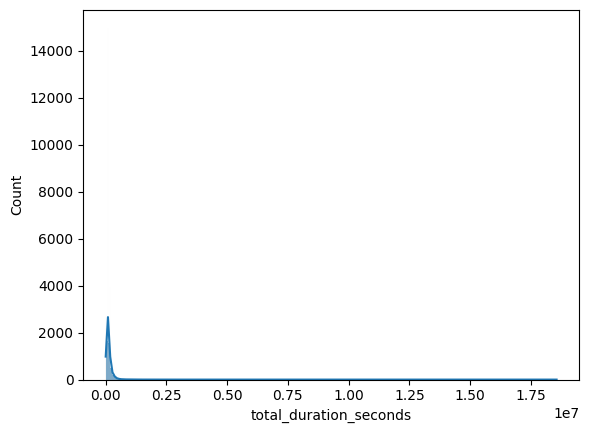

In [164]:
sns.histplot(users_overview['total_duration_seconds'], kde=True)  # Histogram for total duration
plt.show()

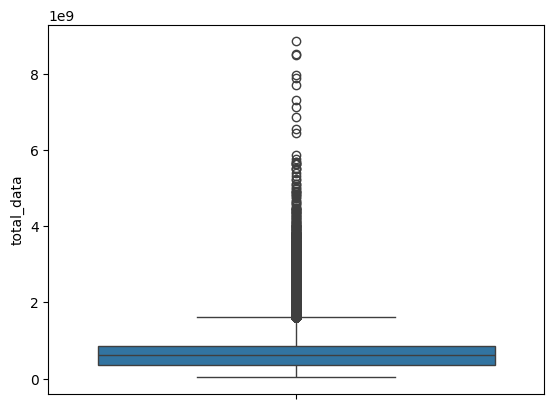

In [165]:
sns.boxplot(users_overview['total_data'])  # Boxplot to visualize outliers
plt.show()

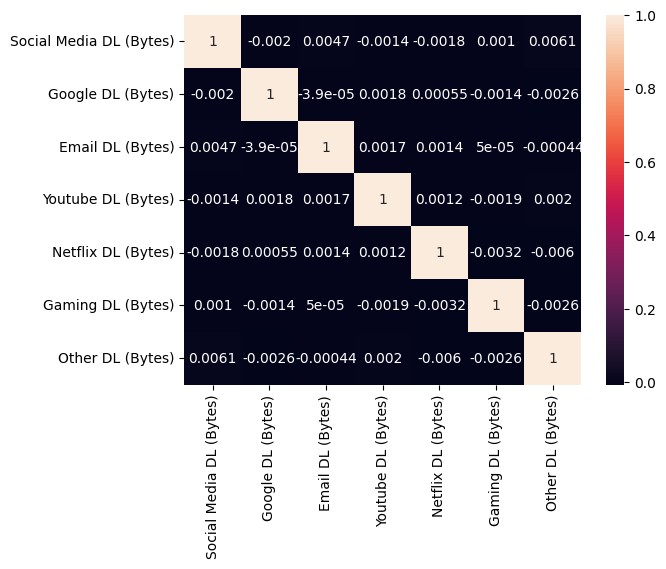

In [172]:
corr_matrix = df[['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 
                  'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [173]:
pca = PCA(n_components=2)  # Reduce to 2 components
data_for_pca = df[['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 
                   'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']]
pca_result = pca.fit_transform(data_for_pca)

# Plot the PCA results
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.show()

KeyError: "['YouTube DL (Bytes)', 'Other DL'] not in index"